In [38]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV

# Seaborn for plotting
import seaborn as sb

import time
import math

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures


### 3) Prediction and Regression

#### 3.2) Bayesian linear regression

In [39]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered,Confirmed_inc,Confirmed_inc_norm,Deaths_inc,Deaths_inc_norm,Recovered_inc,Recovered_inc_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,0.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,NaN,0.0,-0.117725,0.0,-0.110666,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,183.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,183.0,25.0,-0.098276,0.0,-0.110666,59.0,0.003578
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,1267.0,0.0,-0.117725,0.0,-0.110666,0.0,-0.121130


In [40]:
# define helper functions
def get_coords_for_country(country):
    country_row = df.loc[df["Country/Region"] == country]
    return country_row["Lat"].unique()[0], country_row["Long"].unique()[0]

get_coords_for_country("Afghanistan")

(33.0, 65.0)

In [41]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]]
inputs

,Lat_norm,Long_norm,Num_days_from_begin_norm
0,0.471083,0.597360,-1.717183
1,0.798304,-0.039787,-1.717183
2,1.311212,-1.983201,-1.717183
3,0.271776,-0.302833,-1.717183
4,0.852605,-0.304791,-1.717183
...,...,...,...
30619,1.726554,-2.245035,1.717183
30620,0.148971,1.115912,1.717183
30621,-1.472053,0.075543,1.717183
30622,0.317901,1.380346,1.717183


In [42]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"]
outputs

0           0
1           0
2           0
3           0
4           0
         ... 
30619      11
30620     185
30621     679
30622    1268
30623      42
Name: Confirmed, Length: 30624, dtype: int64

In [43]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, random_state=42, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

### Pairs Plot of selected variables

In [44]:
bay = BayesianRidge(compute_score=True)
bay.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': True,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}

In [45]:
bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_in_conf_train = bayesian_poly.fit_transform(in_conf_train)
bayesian_poly_in_conf_test = bayesian_poly.fit_transform(in_conf_test)

In [46]:
# do hyper parameter tuning with the Random Forest, using cross validation
#param_grid = {
#    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
#    'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
#    'alpha_2' : [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
#    'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
#    'lambda_2' : [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 
#     'normalize' : [True, False]
#}

#start = time.time()

#grid_search = GridSearchCV(estimator=bay, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
#search = RandomizedSearchCV(bay, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
#search.fit(in_conf_train, out_conf_train)

#end = time.time()
#elapsed_time = end - start
#print('Elapsed time: {}mins'.format(elapsed_time / 60))
#print('Best score: {}'.format(search.best_score_))
#print('Best parameters: {}'.format(search.best_params_))
#bay_estimator = search.best_estimator_
#bay_estimator


#bay_estimator = BayesianRidge(alpha_1=0.001, alpha_2=1e-05, alpha_init=None,
              #compute_score=False, copy_X=True, fit_intercept=False,
              #lambda_1=1e-06, lambda_2=1e-05, lambda_init=None, n_iter=300,
              #normalize=False, tol=0.001, verbose=False)

#bay_estimator.fit(bayesian_poly_in_conf_train, out_conf_train)


# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_in_conf_train, out_conf_train)

bay_estimator = bayesian_search.best_estimator_



Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.7s finished


MAE: 8448.573185433786
MSE: 1226113870.5578845
RMSE: 35015.90882096143
R^2: 0.05335027555283045


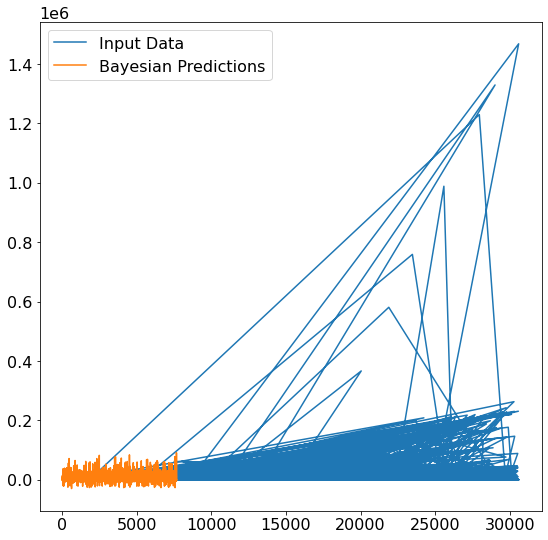

In [47]:
# Calculating statistics
bay_estimator_pred = bay_estimator.predict(bayesian_poly_in_conf_test)
plt.plot(out_conf_test)
plt.plot(bay_estimator_pred)
plt.legend(['Input Data', 'Bayesian Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, bay_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, bay_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, bay_estimator_pred)))
print('R^2:', r2_score(out_conf_test, bay_estimator_pred))

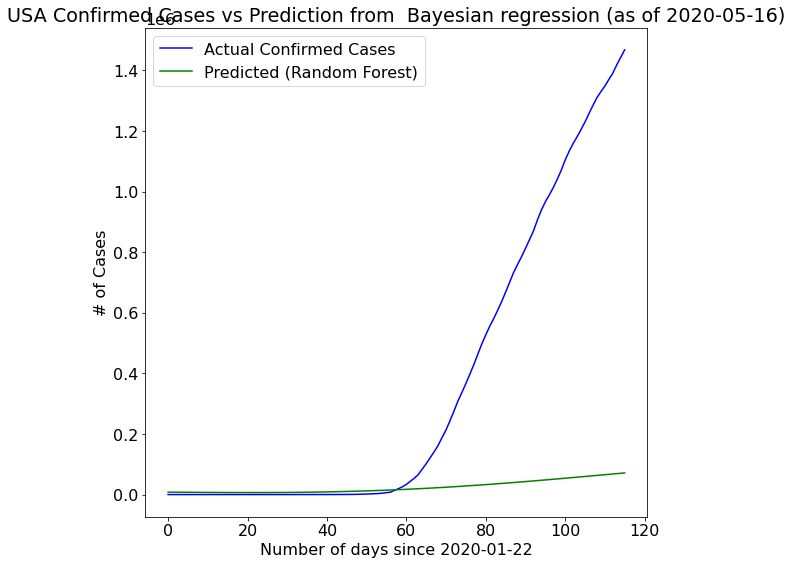

In [48]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
bayesian_poly_usa_inputs = bayesian_poly.fit_transform(usa_inputs)
usa_pred_output = bay_estimator.predict(bayesian_poly_usa_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from  Bayesian regression (as of {})".format(last_day))
plt.legend()